In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict, Counter
from Individual import Individual, Female, Male
import seaborn as sns

from Household import Household
from Bari import Bari
from Village import Village
from Node import Node
from Utility import *
from Demographics import Demographics
import math
import config
from Infection import ImmunoInfection
import dill

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import copy
import re
import glob
from pathlib import Path
import math

import matplotlib.gridspec as gridspec
from math import ceil
import numpy as np
from scipy import linalg

#loading basic statistics of the simulation
taniuchi_data = dill.load(open('../data/cohort_stats.json', 'rb'))
taniuchi_n_individuals = dill.load(open('../data/cohort_stats_n_individuals.json', 'rb'))
taniuchi_incidences = json.load(open('../data/cohort_stats_total_incidence.json', 'r'))
for key in taniuchi_data:
    taniuchi_data[key][np.isnan(taniuchi_data[key])] = 0

taniuchi_n_infected = {}
taniuchi_n_uninfected = {}

fig_directory = #replace me with output for figures
for key in taniuchi_n_individuals: 
    taniuchi_n_infected[key] = taniuchi_data[key] * taniuchi_n_individuals[key]
    taniuchi_n_uninfected[key] = taniuchi_n_individuals[key] - taniuchi_n_infected[key]

In [2]:
import statsmodels.stats.proportion
taniuchi_ci = {}
for key in taniuchi_data:
    if taniuchi_n_individuals[key] > 0:
        p = np.asarray(taniuchi_data[key])
        q = 1- p
        n = taniuchi_n_individuals[key]
        count = p*n
        ci = statsmodels.stats.proportion.proportion_confint(count, n, method = 'agresti_coull')
        taniuchi_ci[key] = ci
    else:
        taniuchi_ci[key] = ([0 for _ in taniuchi_data[key]], [0 for _ in taniuchi_data[key]])


In [3]:
class Sim_Results:
    def __init__(self, file, re_search = True):
        if re_search:
            self.param_conditions = re.search('epidemic_(.+)_prevalences.json', file).groups()[0]
        else:
            self.param_conditions = file
        self.file = file
        data = json.loads(json.load(open(file)))
        self.prevalence = data        
        
    def summarize_transmissions(self):
        self.aggregate_crude_incidence = []
        self.aggregate_n_events_per_level = defaultdict(list)
        self.aggregate_tx_age_matrix = defaultdict(lambda: defaultdict(list))
        self.cohort_incidences = {}
        for key in self.cohort_incidence_time_series.keys():
            data = self.cohort_incidence_time_series[key]
            self.cohort_incidences[key] = np.sum(data, axis = 1)
        
    def plot_prevalence(self, fig_ax = None, color = 'orange', plot_taniuchi_data = False, 
                        x_array = np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]),
                        plot_percentile=True, conditioned = False):
            fontsize = 20
            if not fig_ax:
                fig, ax = plt.subplots(nrows=3, ncols=3)
                fig.set_size_inches(14,7)
            else:
                fig, ax = fig_ax
            i1,i2,i3 = 0,0,0    
            if conditioned:
                prevalence_dict = defaultdict(list)
                for idx, trace in enumerate(self.prevalence['total']):
                    if trace[-1] < 0.001:
                        for key in self.prevalence:
                            prevalence_dict[key].append(self.prevalence[key][idx])
            
            else:
                prevalence_dict = self.prevalence
            
            infant_cohorts = ['infants_b+_i-', 'infants_b+_i-', 'infants_b-_i-']
            hh_cohorts = ['hh_b+_hh+_i+', 'hh_b+_hh+_i-', 'hh_b+_hh-_i+', 'hh_b+_hh-_i-', 'hh_b-_hh-_i-']
            
            primary_cohort = ['infants_b+_i+', 'hh_b+_hh+_i+','hh_b+_hh+_i-']
            short_transmission = ['infants_b+_i-', 'hh_b+_hh-_i+', 'hh_b+_hh-_i-']
            long_transmission = ['infants_b-_i-', 'hh_b-_hh-_i-']
            for key in primary_cohort + short_transmission + long_transmission:
                if key in primary_cohort:
                    row = 0
                    i = i1
                elif key in long_transmission:
                    row = 2
                    i = i2
                else:
                    row = 1 
                    i = i3
                ax[row][i].plot(x_array, np.mean(prevalence_dict[key], axis = 0), color = color, label = self.param_conditions)
                if plot_percentile:
                    ax[row][i].fill_between(x_array, 
                                         np.percentile(prevalence_dict[key], 95, axis = 0),
                                        np.percentile(prevalence_dict[key], 5, axis = 0), 
                                         color = color, alpha = 0.3)
                ax[row][i].set_title(key, fontsize = 15, x = 0.75, y = 0.8)

                for tick in ax[row][i].xaxis.get_major_ticks():
                    tick.label.set_fontsize(15) 
                for tick in ax[row][i].yaxis.get_major_ticks():
                    tick.label.set_fontsize(15) 
                
                if key in primary_cohort:
                    i1 += 1
                elif key in long_transmission:
                    i2 += 1
                else:
                    i3 += 1

            if plot_taniuchi_data:
                i1,i2,i3 = 0,0,0
                for key in primary_cohort + short_transmission + long_transmission:
                    if key in primary_cohort:
                        row = 0
                        i = i1
                    elif key in long_transmission:
                        row = 2
                        i = i2
                    else:
                        row = 1 
                        i = i3
                    ax[row][i].scatter(x_array[1:],taniuchi_data[key][1:], color = 'grey')
                    ax[row][i].fill_between(x_array[1:], 
                                                 [max(0, ci) for ci in taniuchi_ci[key][0][1:]],
                                                 taniuchi_ci[key][1][1:], 
                                                 color = 'grey', alpha = 0.1)
                    if i == 0:
                        ax[row][i].set_ylabel('Prevalence', fontsize = fontsize)
                    if row == 2:
                        ax[row][i].set_xlabel('Weeks', fontsize = fontsize-5)
                    
                    if key in primary_cohort:
                        i1 += 1
                    elif key in long_transmission:
                        i2 += 1
                    else:
                        i3 += 1

            ax[2][2].fill_between(np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]), 
                             np.percentile(prevalence_dict['total'], 5, axis = 0),
                             np.percentile(prevalence_dict['total'], 95, axis = 0), alpha = 0.3, color =color)

            ax[2][2].plot(np.asarray([0,1,2,3,4,5,6,7,8,9,10, 14, 18, 22]), 
             np.mean(prevalence_dict['total'], axis = 0),  color = color)
            ax[2][2].set_title("Total", fontsize = fontsize, y = 0.8, x = 0.75)
            ax[2][2].set_xlabel('Weeks', fontsize = fontsize-5)
            
            for tick in ax[2][2].xaxis.get_major_ticks():
                tick.label.set_fontsize(12) 
            for tick in ax[2][2].yaxis.get_major_ticks():
                tick.label.set_fontsize(12) 
                    
                    
            fig.tight_layout()
            return fig, ax

In [4]:
#code to set up calibration of the contact rates
def intervillage_prior(n_inter, mean = 54):
    #return np.log(mean) - mean * n_inter
    return -(n_inter - mean)**2 / (2*10*mean)

def village_prior(n_village, mean = 140):
    #return np.log(mean) - mean * n_village
    return - (n_village - mean)**2 / (2*10*mean)

def calculate_binomial_likelihood(data, priors= True, cohorts = None):
    x_array = np.asarray([0,1,2,3,4,5,6,7,8,9,10,14,18,22])
    sim_prevalences = data[0]
    cohort_n_individuals = data[1]
    cohort_incidences = {}
    """for key in cohort_incidence_time_series.keys():
        data = cohort_incidence_time_series[key]
        cohort_incidences[key] = np.sum(data, axis = 1)"""
    #L(theta) ~ 1/J * sum_(j=1)^(J)productsum(P(y_n|x_n, j, theta)) equation 11 of https://kingaa.github.io/short-course/pfilter/pfilter.html
    # J = number of traces performed,  the likelihood is approximated as the average likelihood of each trace
    #I do not implement a particle filter for this -- higher dimensional sims will likely require it tho
    #loglikelihood = 0
    #binomial likelihood =p^(n_success) * (1-p) ^(n_failure)#['infants_b+_i-', 'hh_b+_hh-_i+', 'infants_b-_i-', 'hh_b+_hh-_i-', 'hh_b-_hh-_i-']:
    if not cohorts:
        primary_cohort = ['infants_b+_i+', 'hh_b+_hh+_i+','hh_b+_hh+_i-']
        short_transmission = ['infants_b+_i-', 'hh_b+_hh-_i+', 'hh_b+_hh-_i-']
        long_transmission = ['infants_b-_i-', 'hh_b-_hh-_i-']
        cohorts = primary_cohort + short_transmission + long_transmission
    else:
        cohorts = cohorts        
        
        
    likelihoods = defaultdict(list)
    for key in cohorts:
        for i,sim_trace in enumerate(sim_prevalences[key]):
            p = np.asarray([_ if float(_) != 0. else 1/(taniuchi_n_individuals[key] + 1) for _ in sim_trace])
            likelihood_array = p**taniuchi_n_infected[key] * (1-p)**taniuchi_n_uninfected[key] #originally an array of time points
            likelihoods[i] += list(likelihood_array)
    
    if priors:
        if 'inter_village' in data[3][0].keys():
            intervillage_data = data[3][0]['inter_village']
        else:
            intervillage_data = np.zeros(len(likelihoods.keys()))
        #print(intervillage_data)
        if 'village' in data[3][0].keys():
            village_data = data[3][0]['village']
        else:
            village_data =  np.zeros(len(likelihoods.keys()))
        #print(village_data)

        
        for i,intervillage_tx in enumerate(intervillage_data):
            likelihoods[i].append(np.exp(intervillage_prior(intervillage_tx)))

        for i, village_tx in enumerate(village_data):
            likelihoods[i].append(np.exp(village_prior(village_tx)))
    
    for i in likelihoods:
        loglikelihood = (np.sum(np.log(likelihoods[i])))
        likelihoods[i] = loglikelihood
    #print(product_sum_likelihoods)
    #return likelihoods
    final_likelihood = np.mean(list(likelihoods.values()))
    return final_likelihood
    """if key in cohort_incidences.keys():
                if taniuchi_n_individuals[key] != 0:
                    for i,sim_trace in enumerate(cohort_incidences[key]):
                        p = float(taniuchi_incidences[key]) / taniuchi_n_individuals[key]
                        if float(p) == 0.0:
                            p = 1/(taniuchi_n_individuals[key] + 1)
                        loglikelihood += (sim_trace * np.log(p) +  (cohort_n_individuals[key][i] - sim_trace) * np.log(1.-p))"""
    
    #return loglikelihood/len(sim_prevalences[key]) #n_sims

def intervillage_prior(n_inter, mean = 54):
    #return np.log(mean) - mean * n_inter
    return -(n_inter - mean)**2 / (2*10*mean)

def village_prior(n_village, mean = 140):
    #return np.log(mean) - mean * n_village
    return - (n_village - mean)**2 / (2*10*mean)

def calculate_likelihoods(directory='output', return_sim_prevalence = False, priors = True, cohorts = None):
    sim_prevalences = {}
    binomial_loglikelihood = {}    
    for file in glob.glob('../{directory}/*prevalences*json'.format(directory = directory)):
        param_conditions = re.search('{directory}\\\epidemic_(.+)_prevalences.json'.format(directory=directory), file).groups()[0]
        data = json.load(open(file))
        binomial_loglikelihood[param_conditions] = calculate_binomial_likelihood(data, priors = priors, cohorts = cohorts)
    if not return_sim_prevalence:
        return binomial_loglikelihood 
    else:
        return binomial_loglikelihood, sim_prevalences

def profile_likelihood(loglikelihoods):
    sorted_loglikelihoods = sorted(loglikelihoods, key=loglikelihoods.get) 
    param_loglikelihood_dict = defaultdict(lambda: defaultdict(list))
    for condition in sorted_loglikelihoods:
            for param_idx in range(4):
                param = int(condition.split('_')[param_idx])
                param_loglikelihood_dict[param_idx][param].append(loglikelihoods[condition])
    return param_loglikelihood_dict

def plot_profile_likelihoods(likelihoods):
    results = {}
    plt_titles = {0:'Beta_hh', 1: 'Beta_bari', 2: 'Beta_village', 3:'Beta_intervillage'}
    plt.figure(figsize= (15,10))
    for i,_ in enumerate(range(4)):
        plt.subplot(2,2,i+1)
        
        x = [int(x) for x in sorted(likelihoods[i].keys(), reverse=False)]
        y = [max(likelihoods[i][key]) for key in sorted(likelihoods[i].keys(), reverse=False)]
        plt.scatter(x,y)

        if i not in [0,1,2,3,4]:
            regression_polyfit_coefficients, regression_polyfit_covariances = np.polyfit(x, y, 2, cov = True)
            a,b,c = regression_polyfit_coefficients
            maximum = -b/(2*a)
            print(i, maximum)
            plt.plot(np.linspace(0,right,20), regression_polyfit(np.linspace(0,right,20)), color = 'orange')

        plt.title(plt_titles[i])

        plt.scatter(likelihoods[i].keys(), [max(likelihoods[i][key]) for key in likelihoods[i].keys()])
    return results

In [5]:
def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    x= np.asarray(x)
    y = np.asarray(y)
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    
    yest_at_max = np.zeros(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2
        
    i = np.argmax(yest)
    for iteration in range(iter):
        weights_y_max = delta * w[:, i]
        b = np.array([np.sum(weights_y_max * y), np.sum(weights_y_max * y * x)])
        A = np.array([[np.sum(weights_y_max), np.sum(weights_y_max * x)],
                          [np.sum(weights_y_max * x), np.sum(weights_y_max * x * x)]])
        beta = linalg.solve(A, b)
        yest_at_max[i] = beta[0] + beta[1] * x[i]

    residuals = y - yest_at_max
    s = np.median(np.abs(residuals))
    delta = np.clip(residuals / (6.0 * s), -1, 1)
    delta = (1 - delta ** 2) ** 2

    return yest, weights_y_max

In [6]:
results = defaultdict(lambda: {})
for multiplier in ['1.0', '5.0', '10.0']:
    for file in glob.glob('../output/dose_{x}/combined_epidemic.json'.format(x = multiplier)):
        print(file)
        results[multiplier] = json.load(open(file))
        #p = Path(file)
        #param_conditions = re.search('(.+)_epidemic.json', p.name).groups()[0]
        #results[multiplier][param_conditions] = Sim_Results(file, re_search = False)
    

../output/dose_1.0/combined_epidemic.json
../output/dose_5.0/combined_epidemic.json
../output/dose_10.0/combined_epidemic.json


In [7]:
all_keys = []
years = [1,2,3,4,5]#[1,2,3,4,5]
fdoses = [1.0]
for year in years:
    for p in [x/10. for x in range(5)]:#range(9)]:
        for fdose in fdoses:
            all_keys.append('S2_{p}_{y}_{f}'.format(p=p, y=year, f= '{f}'))

In [8]:
all_keys = defaultdict(list)
years = [1,2,3,4,5]
fdoses = [1.0, 5.0, 10.0]
for year in years:
    for p in [x/10. for x in [1,3,5,7,9]]:#range(9)]:
        for fdose in fdoses:
            all_keys[fdose].append('S2_{p}_{y}_{f}'.format(p=p, y=year, f= fdose))
            
vaccination_campaign = defaultdict(list)
importation = defaultdict(list)
data_dict = defaultdict(lambda: defaultdict(list))
epidemic_data = defaultdict(lambda: {})


for fdose in fdoses:
    combined_base_file = '../output/dose_{f}/combined_epidemic.json'.format(f = fdose, x = '{x}')
    print(combined_base_file)
    epidemic_raw = json.load(open(combined_base_file))
    for key in epidemic_raw:
        epidemic_data[fdose][key] = epidemic_raw[key]
        epidemic_curve = np.asarray([ x[0] for x in epidemic_data[fdose][key]['total']])
        bootstrap_resample_idxes = np.random.randint(0, len(epidemic_curve) -1, (500, len(epidemic_curve)))
        epidemic_data[fdose][key]['endemic_prob'] = []
        for idxes in bootstrap_resample_idxes:
            resample = epidemic_curve[idxes]
            endemic_prob = np.mean(np.asarray([len(simulation) for simulation in resample]) == 1096)
            epidemic_data[fdose][key]['endemic_prob'].append(endemic_prob)

missing_keys =defaultdict(list)
for fdose in fdoses:
    for key in all_keys[fdose]:
        if key not in epidemic_data[fdose]:
            missing_keys[fdose].append(key)


../output/dose_1.0/combined_epidemic.json


/var/folders/27/jdv7q8tn02v65x59xkkym7kr0000gn/T/ipykernel_25892/2092823335.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  epidemic_curve = np.asarray([ x[0] for x in epidemic_data[fdose][key]['total']])


../output/dose_5.0/combined_epidemic.json
../output/dose_10.0/combined_epidemic.json


In [9]:
vaccination_campaign = defaultdict(list)
importation = defaultdict(list)
for fdose in fdoses:
    for p in reversed([x/10 for x in [1,3,5,7,9]]):
            tmp_array = []
            for year in years:
                param = 'S2_{p}_{y}_{f}'.format(y = year, p = p, f= fdose)
                print(param, len(epidemic_data[fdose][param]['total']))
                tmp_array.append(np.mean(epidemic_data[fdose][param]['endemic_prob']))
            vaccination_campaign[fdose].append(tmp_array)

for year in years:
    for fdose in fdoses:
        param = 'S2_0.0_{y}_{f}'.format(y = year, f = fdose)
        importation[fdose].append(np.mean(epidemic_data[fdose][param]['endemic_prob']))
        print(param, len(epidemic_data[fdose][param]['total']))
    
    
    

S2_0.9_1_1.0 400
S2_0.9_2_1.0 400
S2_0.9_3_1.0 400
S2_0.9_4_1.0 400
S2_0.9_5_1.0 400
S2_0.7_1_1.0 400
S2_0.7_2_1.0 400
S2_0.7_3_1.0 400
S2_0.7_4_1.0 400
S2_0.7_5_1.0 400
S2_0.5_1_1.0 400
S2_0.5_2_1.0 400
S2_0.5_3_1.0 400
S2_0.5_4_1.0 400
S2_0.5_5_1.0 400
S2_0.3_1_1.0 400
S2_0.3_2_1.0 400
S2_0.3_3_1.0 400
S2_0.3_4_1.0 400
S2_0.3_5_1.0 400
S2_0.1_1_1.0 389
S2_0.1_2_1.0 400
S2_0.1_3_1.0 400
S2_0.1_4_1.0 400
S2_0.1_5_1.0 400
S2_0.9_1_5.0 900
S2_0.9_2_5.0 900
S2_0.9_3_5.0 900
S2_0.9_4_5.0 900
S2_0.9_5_5.0 900
S2_0.7_1_5.0 900
S2_0.7_2_5.0 900
S2_0.7_3_5.0 900
S2_0.7_4_5.0 900
S2_0.7_5_5.0 900
S2_0.5_1_5.0 900
S2_0.5_2_5.0 900
S2_0.5_3_5.0 900
S2_0.5_4_5.0 899
S2_0.5_5_5.0 900
S2_0.3_1_5.0 896
S2_0.3_2_5.0 900
S2_0.3_3_5.0 899
S2_0.3_4_5.0 900
S2_0.3_5_5.0 899
S2_0.1_1_5.0 896
S2_0.1_2_5.0 900
S2_0.1_3_5.0 900
S2_0.1_4_5.0 900
S2_0.1_5_5.0 900
S2_0.9_1_10.0 900
S2_0.9_2_10.0 898
S2_0.9_3_10.0 900
S2_0.9_4_10.0 897
S2_0.9_5_10.0 895
S2_0.7_1_10.0 899
S2_0.7_2_10.0 899
S2_0.7_3_10.0 899
S2_0.7

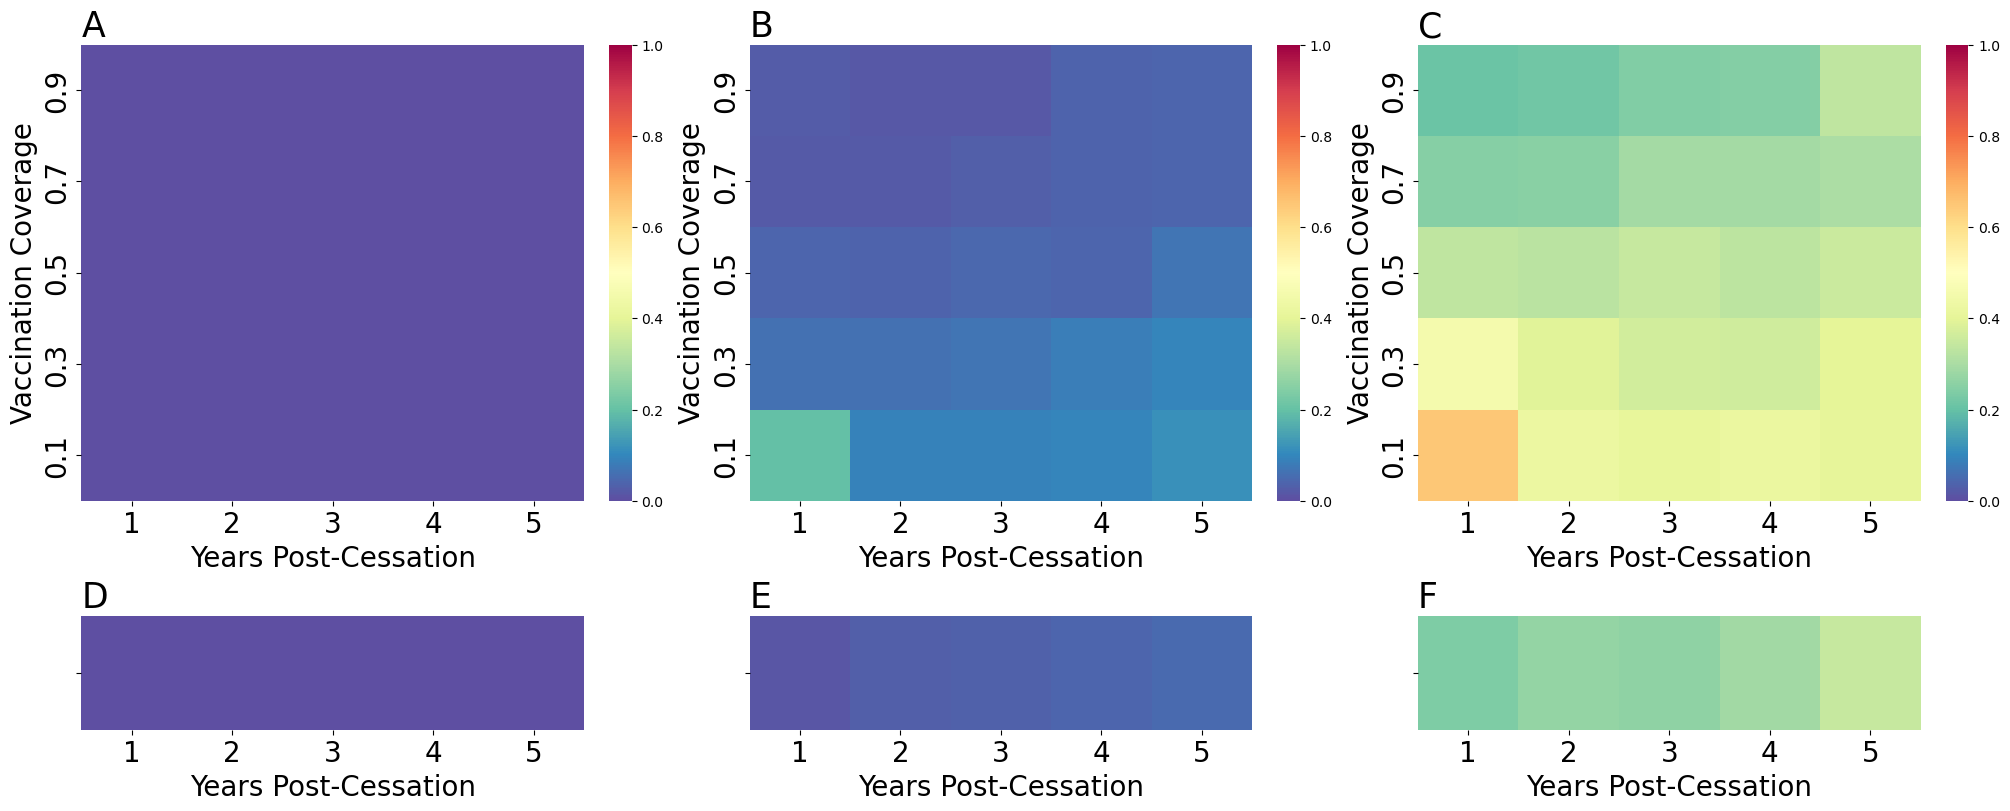

In [10]:
fig = plt.figure(figsize=(20, 8), constrained_layout=True)
nrows = 5
spec = fig.add_gridspec(ncols=3, nrows=nrows)
coverages = [1,3,5,7,9]
years = [1,2,3,4,5]

titles = 'ABC'
titles2 = 'DEF'
row1_axes = [fig.add_subplot(spec[0:nrows-1,_]) for _ in range(3)]
row2_axes = [fig.add_subplot(spec[nrows-1,_]) for _ in range(3)]
for idx, dose_multiplier in enumerate([1.0, 5.0, 10.0]):
    ax = row1_axes[idx]
    ax2 = row2_axes[idx]
    sns.heatmap(vaccination_campaign[dose_multiplier], 
                xticklabels = years, 
                yticklabels=[coverage for coverage in reversed([x/10 for x in coverages])],
               vmin = 0, vmax = 1., center = 0.5, cbar = True,cmap = 'Spectral_r', ax = ax)
    ax.set_xlabel('Years Post-Cessation', fontsize = 20)
    ax.set_ylabel('Vaccination Coverage', fontsize = 20)
    ax.tick_params(axis = 'both', labelsize = 20)
    ax.set_title(titles[idx], fontsize = 25, loc = 'left')
    
    sns.heatmap([importation[dose_multiplier]], 
                xticklabels = years, yticklabels=[''],
               vmin = 0, vmax = 1., center = 0.5, cbar = False,cmap='Spectral_r', ax = ax2)
    
    ax2.set_xlabel('Years Post-Cessation', fontsize = 20)
    ax2.tick_params(axis = 'both', labelsize = 20)
    ax2.set_title(titles2[idx], fontsize = 25, loc = 'left')
    
#fig.savefig(fig_directory + 'Figure 5 Heatmap.svg')

In [11]:
class Sim_Class:
    def __init__(self, sim, endemic_threshold = 1096):
        self.sim = np.asarray(sim[0])
        self.shape = np.shape(sim[0])
        if self.shape[0] == endemic_threshold:
            self.endemic = True
        else:
            self.endemic = False
        self.means = self.sim.T[0]
        self.low = self.sim.T[1]
        self.high = self.sim.T[2]

genetics_file = '../output/dose_genetics/combined_genetics_S2_0.1_1_10.0.json'
genetics_json = json.load(open(genetics_file))
genetics_sims = defaultdict(list)
            
for key in genetics_json:
    for sim in genetics_json[key]:
        genetics_sims[key].append(Sim_Class(sim, endemic_threshold = 1095))
endemic_mask = np.asarray([S.endemic for S in genetics_sims['A481G']])

endemic_genetic_sims = {}
for key in genetics_sims:
    endemic_genetic_sims[key] = np.asarray(genetics_sims[key])[endemic_mask]

transient_genetic_sims = {}
for key in genetics_sims:
    transient_genetic_sims[key] = np.asarray(genetics_sims[key])[~endemic_mask]

epidemic_file = '../output/dose_genetics/combined_epidemic_S2_0.1_1_10.0.json'
epidemic_sims = json.load(open(epidemic_file))
focus_epidemic = [Sim_Class(sim) for sim in epidemic_sims['S2_0.1_1_10.0']['total']]
endemic_epidemic_sims = np.asarray(focus_epidemic)[endemic_mask]
transient_epidemic_sims = np.asarray(focus_epidemic)[~endemic_mask]


immunity_file = '../output/dose_genetics/combined_immunity_S2_0.1_1_10.0.json'
immunity_sims = json.load(open(immunity_file))

focus_immunity = {}
endemic_immunity = {}
transient_immunity = {}
for key in immunity_sims['S2_0.1_1_10.0']:
    print(key)
    focus_immunity[key] = [Sim_Class(sim) for sim in immunity_sims['S2_0.1_1_10.0'][key]]
    endemic_immunity[key] = np.asarray(focus_immunity[key])[endemic_mask]
    transient_immunity[key] = np.asarray(focus_immunity[key])[~endemic_mask]



mid_5-15
high_5-15
low_5-15
mid
high
mid_15+
mid_0-5
high_15+
low
low_15+
low_0-5
high_0-5


In [17]:
class Sim_Class:
    def __init__(self, sim, endemic_threshold = 1096):
        self.sim = np.asarray(sim[0])
        self.shape = np.shape(sim[0])
        if self.shape[0] == endemic_threshold:
            self.endemic = True
        else:
            self.endemic = False
        self.means = self.sim.T[0]
        self.low = self.sim.T[1]
        self.high = self.sim.T[2]
        
class Big_Structure:
    def __init__(self, parameter):
        genetics_file = '../output/dose_genetics/combined_genetics_{parameter}.json'.format(parameter = parameter)
        epidemic_file = '../output/dose_genetics/combined_epidemic_{parameter}.json'.format(parameter = parameter)
        immunity_file = '../output/dose_genetics/combined_immunity_{parameter}.json'.format(parameter = parameter)
        
        
        epi_json = json.load(open(epidemic_file))
        genetics_json = json.load(open(genetics_file))
        immunity_json = json.load(open(immunity_file))
    
        print('interpreting genetics')
        self.endemic_genetics, self.transient_genetics, self.genetics_sims={}, {},defaultdict(list)
        for key in genetics_json:
            for sim in genetics_json[key]:
                self.genetics_sims[key].append(Sim_Class(sim, endemic_threshold = 1095))
            self.endemic_mask = np.asarray([S.endemic for S in self.genetics_sims['A481G']])
            self.endemic_genetics[key] = np.asarray(self.genetics_sims[key])[self.endemic_mask]
            self.transient_genetics[key] = np.asarray(self.genetics_sims[key])[~self.endemic_mask]
        
        self.epi_sims = [Sim_Class(sim) for sim in epi_json[parameter]['total']]
        self.endemic_epi, self.transient_epi = {}, {}
        print('interpreting epi')
        self.endemic_epi = np.asarray(self.epi_sims)[self.endemic_mask]
        self.transient_epi = np.asarray(self.epi_sims)[~self.endemic_mask]
        
        self.immunity, self.endemic_immunity, self.transient_immunity = {},{}, {}
        for key in immunity_json[parameter]:
            self.immunity[key] = [Sim_Class(sim) for sim in immunity_json[parameter][key]]
            self.endemic_immunity[key] = np.asarray(self.immunity[key])[self.endemic_mask]
            self.transient_immunity[key] = np.asarray(self.immunity[key])[~self.endemic_mask]
        
focus_sim1 = Big_Structure('S2_0.1_1_10.0')

focus_sim2 = Big_Structure('S2_0.1_5_10.0')

interpreting genetics
interpreting epi
interpreting genetics
interpreting epi


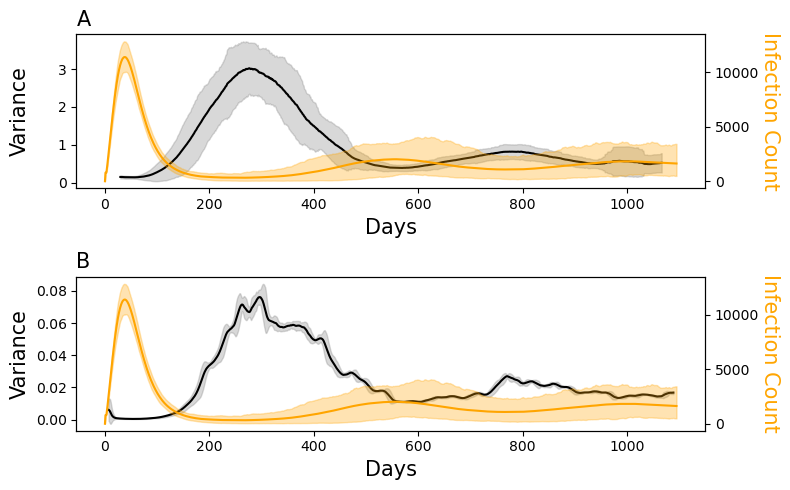

In [13]:
fig, axes = plt.subplots(2,1, figsize =(8,5))

ax1 = axes[0]
#duration_var = np.var(genetics_data['endemic_duration_fitness_mean'], axis = 0)
duration_var = np.var([S.means for S in focus_sim1.endemic_genetics['duration_fitness']], axis = 0)
def return_mean_window(seq, window_size = 60):
    windows = []
    for i in range(len(seq) - window_size + 5):
        window = seq[i: i + window_size]
        windows.append((np.mean(window),np.std(window)))
    return windows


X_windowed = [x[0] for x in return_mean_window(range(1095))]
duration_var_windowed = return_mean_window(duration_var)
mean_duration_var =  np.asarray([x[0] for x in duration_var_windowed])
std_duration_var  =  np.asarray([x[1] for x in duration_var_windowed])
ax1.plot(X_windowed, mean_duration_var, color = 'black')
ax1.fill_between(X_windowed, mean_duration_var + 1.96 * std_duration_var,
                 mean_duration_var - 1.96 * std_duration_var,
                color = 'grey', alpha = 0.3)


ax1.set_xlabel('Days', fontsize = 15)
ax1.set_ylabel('Variance', fontsize = 15, labelpad = 20)

ax2 = ax1.twinx()  
ax2.set_ylabel('Infection Count', fontsize = 15, rotation = -90, 
               color = 'orange', labelpad = 15)

epidemic_curve = np.asarray([S.sim for S in focus_sim1.endemic_epi])
ax2.plot(range(1096), np.mean(epidemic_curve, axis = 0), color = 'orange')
ax2.fill_between(range(1096), 
                 np.percentile(epidemic_curve, 2.5, axis = 0),
                 np.percentile(epidemic_curve, 97.5, axis = 0),
                 color = 'orange', alpha = 0.3)
ax2.set_title('A', fontsize = 15, loc = 'left')



ax3 = axes[1]
transmission_var = np.var([S.means for S in focus_sim1.endemic_genetics['transmission_fitness']], axis = 0)
X_windowed = [x[0] for x in return_mean_window(range(1095),15)]
tx_var_windowed = return_mean_window(transmission_var, 15)
mean_duration_var =  np.asarray([x[0] for x in tx_var_windowed])
std_duration_var  =  np.asarray([x[1] for x in tx_var_windowed])
ax3.plot(X_windowed, mean_duration_var, color = 'black')
ax3.fill_between(X_windowed, mean_duration_var + 1.96 * std_duration_var,
                 mean_duration_var - 1.96 * std_duration_var,
                color = 'grey', alpha = 0.3)

ax3.set_xlabel('Days', fontsize = 15)
ax3.set_ylabel('Variance', fontsize = 15)

ax4 = ax3.twinx()  
epidemic_curve = np.asarray([S.sim for S in focus_sim1.endemic_epi])
ax4.plot(range(1096), np.mean(epidemic_curve, axis = 0), color = 'orange')
ax4.fill_between(range(1096), 
                 np.percentile(epidemic_curve, 2.5, axis = 0),
                 np.percentile(epidemic_curve, 97.5, axis = 0),
                 color = 'orange', alpha = 0.3)
ax4.set_ylabel('Infection Count', fontsize = 15, rotation = -90, color = 'orange', labelpad = 15)
ax4.set_title('B', fontsize = 15, loc = 'left')

fig.tight_layout()

#plt.savefig(fig_directory + 'Supplemental Figure 3 variance.svg', bbox_inches = 'tight')

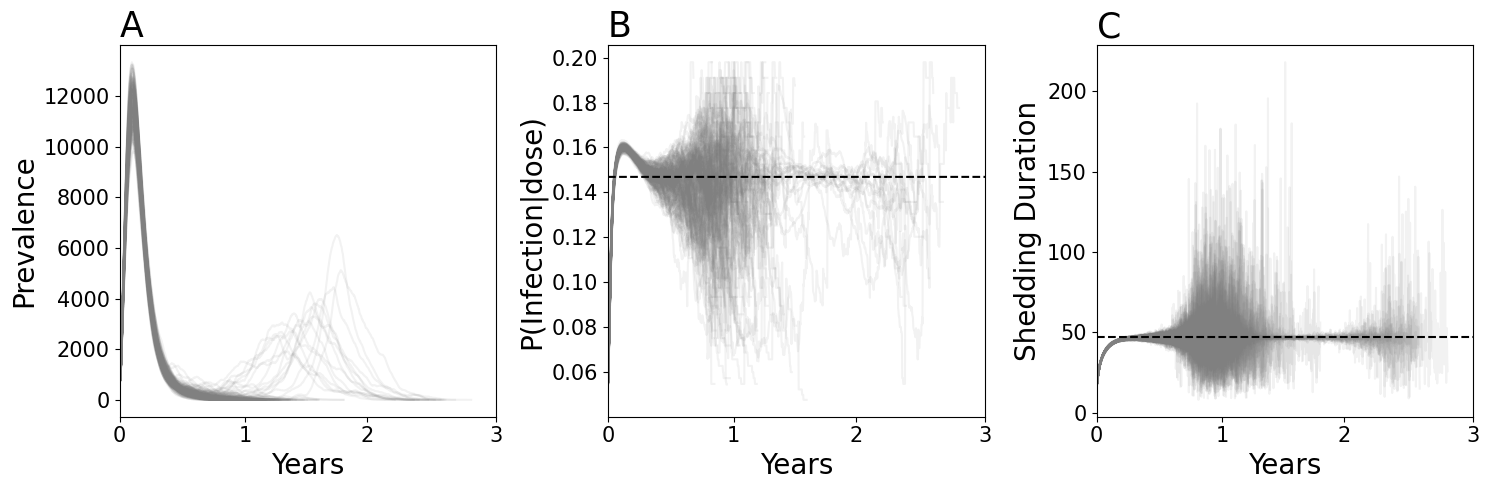

In [14]:
#{'alpha':0.44, 'beta': 8, 'gamma': 0.4624},
def p_infection(w, dose, immunity = 1, alpha = 0.44, gamma = 0.4624):
    p_infection = (1 - (1 + dose/w)**(-alpha * (immunity)**-gamma)) #* 0.554
    return(p_infection)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
for S in focus_sim1.transient_epi:
    plt.plot(range(len(S.sim)), S.sim, color = 'grey', alpha = 0.1)
plt.xlim(0,365*3)
plt.ylabel('Prevalence', fontsize = 20)
plt.xlabel('Years', fontsize = 20)
plt.xticks([0, 365, 720, 365 *3], [0,1,2,3], fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('A', fontsize = 25, loc = 'left')

plt.subplot(1,3,2)
p_array = []
for S in focus_sim1.transient_genetics['transmission_fitness']:
    p_infection_array = [p_infection(x,1) for x in S.means]
    plt.plot(range(len(S.sim)), p_infection_array, color = 'grey', alpha = 0.1)
    #p_array.append(p_infection_array)

plt.plot(range(7300), [p_infection(2.3,1) for x in range(7300)], linestyle = '--', color = 'black', label = 'WPV')
plt.xlim(0,365*3)
plt.ylabel('P(Infection|dose)', fontsize = 20)
plt.xlabel('Years', fontsize = 20)
plt.xticks([0, 365, 720, 365 *3], [0,1,2,3], fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('B', fontsize = 25, loc = 'left')


plt.subplot(1,3,3)

for S in focus_sim1.transient_genetics['duration_fitness']:
    plt.plot(range(len(S.means)), S.means, color = 'grey', alpha = 0.1)
    
plt.plot([0,7300], [47, 47], linestyle = '--', color = 'black', label = 'WPV')
plt.title('C', fontsize = 25, loc = 'left')
plt.ylabel('Shedding Duration', fontsize = 20)
plt.xlabel('Years', fontsize = 20)
plt.xticks([0, 365, 720, 365 *3], [0,1,2,3], fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0,365*3)
plt.tight_layout()
#plt.savefig(fig_directory + 'Supplemental Figure 2 variance.svg', bbox_inches = 'tight')

(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

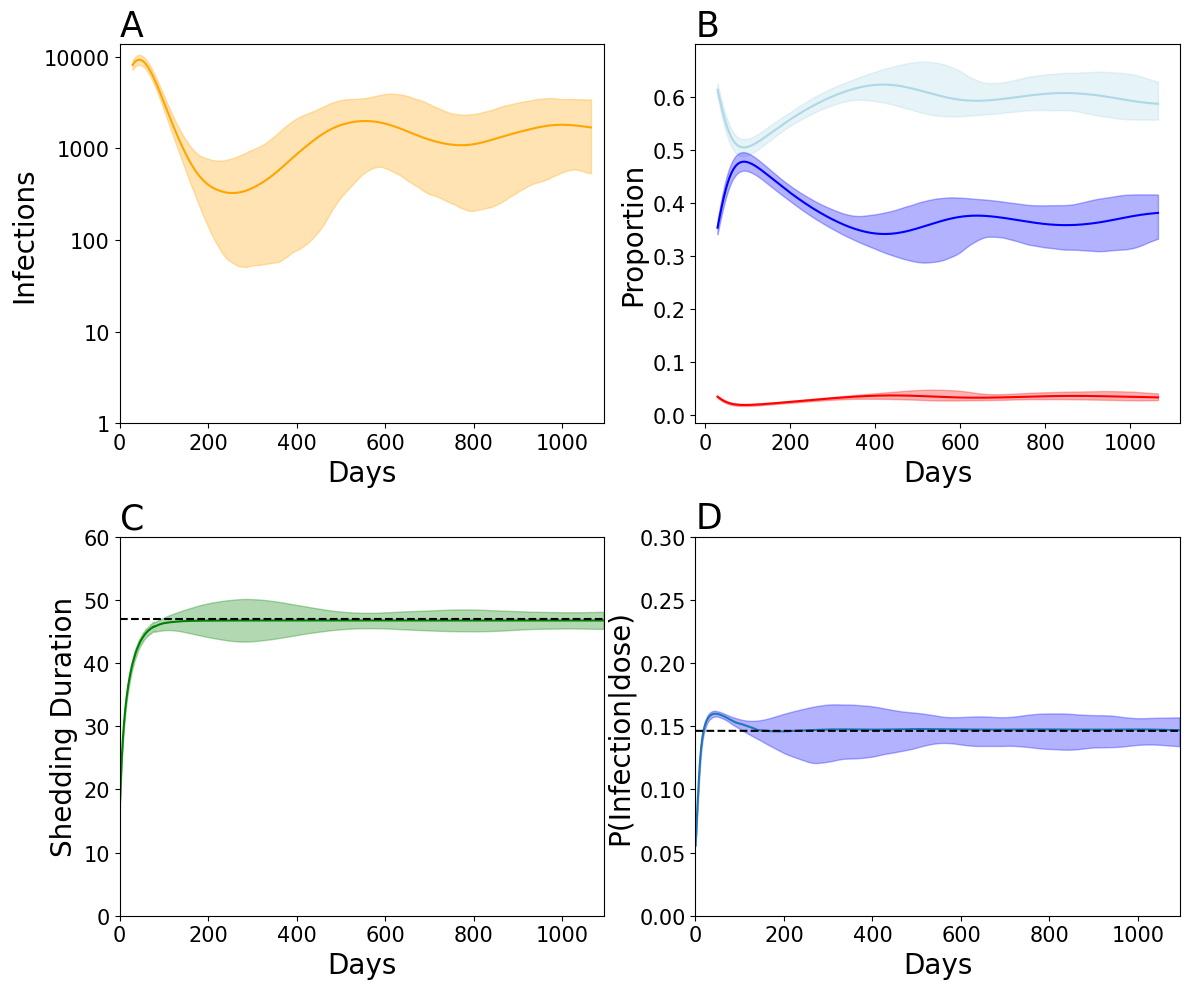

In [15]:
def return_mean_window(seq, window_size = 60):
    windows = []
    for i in range(len(seq) - window_size + 1):
        window = seq[i: i + window_size]
        windows.append((np.mean(window),np.std(window)))
    return windows


plt.figure(figsize=(12,10))
plt.subplot(2,2,1)

simulations = [S.sim for S in focus_sim1.endemic_epi]
sim_average = np.mean(simulations, axis = 0)
sim_low = np.percentile(simulations, 2.5, axis = 0)
sim_high = np.percentile(simulations, 97.5, axis = 0)
windowed_sim_average = np.log10([x[0] for x in return_mean_window(sim_average)])
windowed_sim_low = np.log10([x[0] for x in return_mean_window(sim_low)])
windowed_sim_high = np.log10([x[0] for x in return_mean_window(sim_high)])
windowed_X = [x[0] for x in return_mean_window(range(1096))]
plt.plot(windowed_X, windowed_sim_average, color = 'orange')
plt.fill_between(windowed_X, windowed_sim_low,windowed_sim_high, alpha = 0.3, color = 'orange')

plt.xlim(0,365*3)
ylow,yhigh = plt.ylim()
plt.ylabel('Infections', fontsize = 20)
plt.xlabel('Days', fontsize = 20)
plt.xticks(fontsize = 15)
yticks = [0,1,2,3,4]
plt.yticks(yticks, [10**y for y in yticks], fontsize = 15)
plt.title('A', fontsize = 25, loc = 'left')


plt.subplot(2,2,2)
colors = ['red', 'lightblue', 'blue']
for i, immunity_level in enumerate(['low','mid', 'high']):
    simulations = [SimR.sim for SimR in focus_sim1.endemic_immunity[immunity_level]]
    sim_average = np.mean(simulations, axis = 0)
    sim_low = np.percentile(simulations, 2.5, axis = 0)
    sim_high = np.percentile(simulations, 97.5, axis = 0)
    windowed_sim_average = [x[0] for x in return_mean_window(sim_average)]
    windowed_sim_low = [x[0] for x in return_mean_window(sim_low)]
    windowed_sim_high = [x[0] for x in return_mean_window(sim_high)]
    
    plt.plot(windowed_X, windowed_sim_average, color = colors[i])
    plt.fill_between(windowed_X, windowed_sim_low,windowed_sim_high, alpha = 0.3, color = colors[i])

plt.title('B', fontsize = 25, loc = 'left')
plt.xlabel('Days', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


plt.subplot(2,2,3)  
simulations = [x.means for x in focus_sim1.endemic_genetics['duration_fitness']]
sim_average = np.mean(simulations, axis = 0)
sim_low = np.percentile(simulations, 2.5, axis = 0)
sim_high = np.percentile(simulations, 97.5, axis = 0)
lowess_y_mean, weights_at_max = lowess(range(len(sim_average)), sim_average, f = 0.10)
lowess_y_low, weights_at_max = lowess(range(len(sim_average)), 
                                  sim_low, f = 0.10)
lowess_y_high, weights_at_max = lowess(range(len(sim_average)), 
                                  sim_high, f = 0.10)
    
plt.plot(range(len(sim_average)), list(sim_average[0:80]) + list(lowess_y_mean[80:]), color = 'green')
plt.fill_between(range(len(sim_low)), list(sim_low[0:80]) + list(lowess_y_low[80:]),
                 list(sim_high[0:80]) + list(lowess_y_high[80:]), 
                 alpha = 0.3, color = 'green')
plt.plot([0,len(sim_average)], [47,47], color = 'black', linestyle = '--')
plt.ylim(0,60)

plt.title('C', fontsize = 25, loc = 'left')
plt.ylabel('Shedding Duration', fontsize = 20)
plt.xlabel('Days', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0,365*3)
plt.tight_layout()


plt.subplot(2,2,4)

simulations = [p_infection(x.means,1) for x in focus_sim1.endemic_genetics['transmission_fitness']]
sim_averages = np.mean(simulations, axis = 0)
sim_low = np.percentile(simulations, 2.5, axis = 0)
sim_high = np.percentile(simulations, 97.5, axis = 0)

lowess_y_mean, weights_at_max = lowess(range(len(sim_averages)), sim_averages, f = 0.10)
lowess_y_low, weights_at_max = lowess(range(len(sim_averages)), 
                                  sim_low, f = 0.10)
lowess_y_high, weights_at_max = lowess(range(len(sim_averages)), 
                                  sim_high, f = 0.10)
    
plt.plot(range(len(sim_averages)), list(sim_averages[0:80]) + list(lowess_y_mean[80:]))
plt.fill_between(range(len(sim_low)), list(sim_low[0:80]) + list(lowess_y_low[80:]),
                 list(sim_high[0:80]) + list(lowess_y_high[80:]), 
                 alpha = 0.3, color = 'blue')

plt.ylim(0,0.3)
#plt.fill_between(range(1,1096), 
#                 np.percentile(sim_averages, 2.5, axis = 0),
#                 np.percentile(sim_averages, 97.5, axis = 0),
#                 color = 'blue', alpha = 0.3)
    
#plt.plot(range(1,1096), np.mean(sim_averages, axis = 0), color = 'blue')

#plt.plot(range(1,1096), np.mean(sim_lows, axis = 0), color = 'blue', linestyle='--')
#plt.plot(range(1,1096), np.mean(sim_highs, axis = 0), color = 'blue', linestyle = '--')


ylow,yhigh = plt.ylim()
plt.plot(range(7300), [p_infection(2.31,1) for x in range(7300)], linestyle = '--', color = 'black')
plt.xlim(0,365*3)
plt.ylabel('P(Infection|dose)', fontsize = 20)
plt.yticks(fontsize = 15)
plt.title('D', fontsize = 25, loc = 'left')
plt.xlabel('Days', fontsize = 20)
plt.xticks(fontsize = 15)

#fig.savefig(fig_directory + 'Figure 4 Evo-epi dynamics.svg')

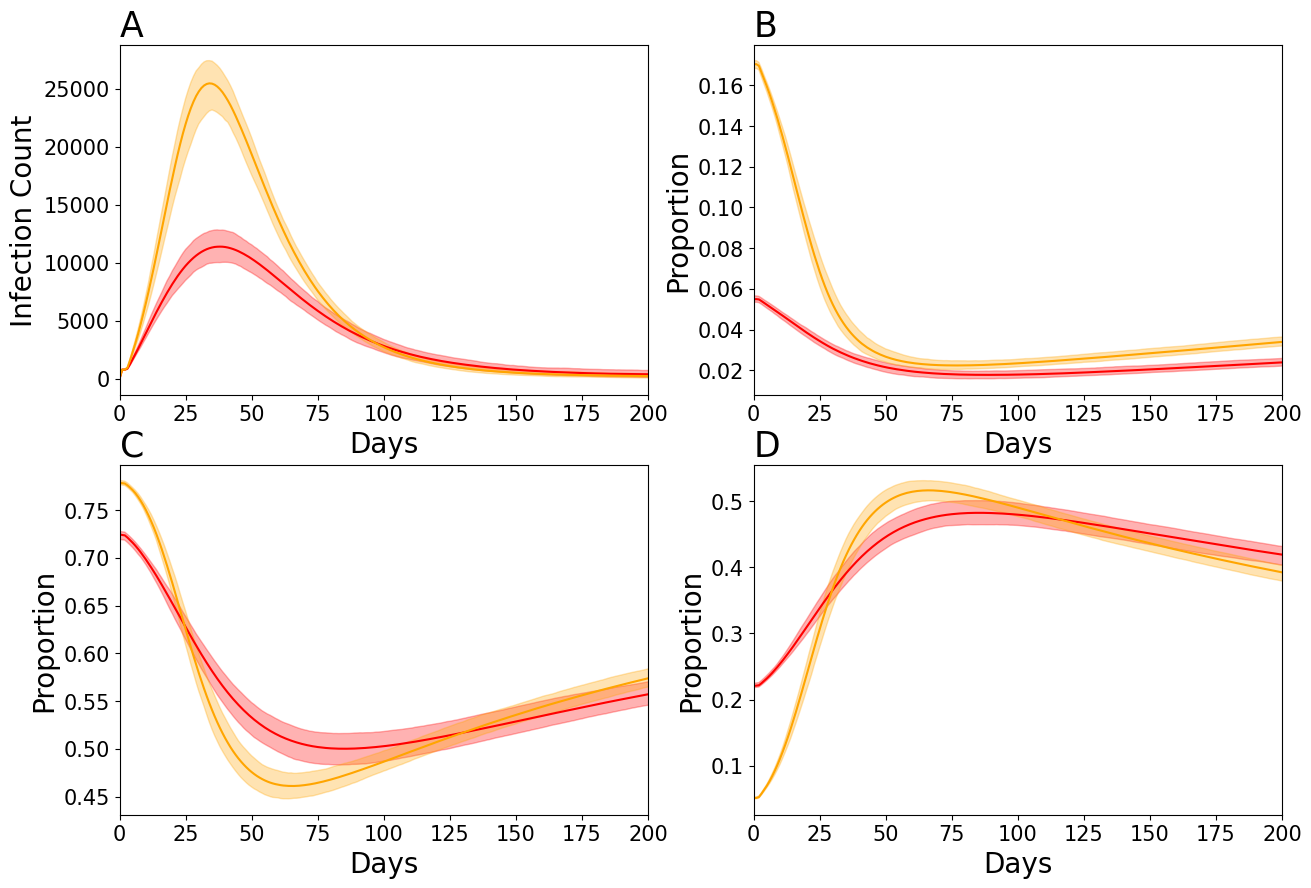

In [20]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
simulations = [SimR.sim for SimR in focus_sim1.endemic_epi]
plt.plot(range(1096), 
             np.mean(simulations, axis = 0), c= 'red')
plt.fill_between(range(1096), 
                     np.percentile(simulations, 2.5, axis = 0),
                     np.percentile(simulations, 97.5, axis = 0), 
                     alpha = 0.3, color= 'red', label = 'low')

simulations = [SimR.sim for SimR in focus_sim2.endemic_epi]
plt.plot(range(1096), 
             np.mean(simulations, axis = 0), c= 'orange')
plt.fill_between(range(1096), 
                     np.percentile(simulations, 2.5, axis = 0),
                     np.percentile(simulations, 97.5, axis = 0), 
                     alpha = 0.3, color= 'orange', label = 'low')
plt.title('A', fontsize = 25, loc = 'left')
plt.xlabel('Days', fontsize = 20)
plt.ylabel('Infection Count', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlim(0,200)


for i, immunity_level in enumerate(['low', 'mid','high']):
    plt.subplot(2,2,i+2)
    simulations = [SimR.sim for SimR in focus_sim1.endemic_immunity[immunity_level]]
    plt.plot(range(1096), 
             np.mean(simulations, axis = 0), c= 'red')
    plt.fill_between(range(1096), 
                     np.percentile(simulations, 2.5, axis = 0),
                     np.percentile(simulations, 97.5, axis = 0), 
                     alpha = 0.3, color= 'red', label = 'low')

    simulations = [SimR.sim for SimR in focus_sim2.endemic_immunity[immunity_level]]
    plt.plot(range(1096), 
             np.mean(simulations, axis = 0), c= 'orange')
    plt.fill_between(range(1096), 
                     np.percentile(simulations, 2.5, axis = 0),
                     np.percentile(simulations, 97.5, axis = 0), 
                     alpha = 0.3, color= 'orange', label = 'low')
    
    plt.title('BCD'[i], fontsize = 25, loc = 'left')
    plt.xlabel('Days', fontsize = 20)
    plt.ylabel('Proportion', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlim(0,200)
    

plt.savefig(fig_directory + 'Supplemental Figure 4.svg')
